# VGG

In [1]:
import chainer
import pickle
import numpy as np

## 訓練データ

cifar10から作成したサイズの小さいデータセット  
・飛行機、自動車、鳥の3クラス  
・各100枚の画像とラベル

In [2]:
with open('data/classification_data.pkl', 'rb') as f:
    dic = pickle.load(f)

data = dic['data']
labels = dic['labels']
label_names = dic['label_names']
print(data.shape, labels.shape, label_names)

(300, 3072) (300,) [b'airplane', b'automobile', b'bird']


In [3]:
# データchainerに適する形に変換（型はfloat32 or int32、画像は(batch_size, channel, width, height)）
# 画像は255で割って0~1に変換
data = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
labels = np.array(labels, dtype=np.int32)

In [4]:
# イテレーターを作成
train = chainer.datasets.TupleDataset(data, labels)
train_iter = chainer.iterators.SerialIterator(train, batch_size=64)

## モデル

サイズの小さいVGG

In [5]:
from chainer import functions as F
from chainer import initializers
from chainer import links as L

class VGG(chainer.Chain):
    
    def __init__(self, n_class=3):
        super(VGG, self).__init__()
        
        init = {
            'initialW': initializers.Normal(0.01),
            'initial_bias': initializers.Zero(),
            }
        
        with self.init_scope():
            self.conv1_1 = L.Convolution2D(None, 64, 3, pad=1, **init)
            self.bn1_1 = L.BatchNormalization(64)
            self.conv1_2 = L.Convolution2D(64, 64, 3, pad=1, **init)
            self.bn1_2 = L.BatchNormalization(64)

            self.conv2_1 = L.Convolution2D(64, 128, 3, pad=1, **init)
            self.bn2_1 = L.BatchNormalization(128)
            self.conv2_2 = L.Convolution2D(128, 128, 3, pad=1, **init)
            self.bn2_2 = L.BatchNormalization(128)

            self.fc3 = L.Linear(None, 1024, **init)
            self.fc4 = L.Linear(1024, n_class, **init)

    def __call__(self, x):
        h = F.relu(self.bn1_1(self.conv1_1(x)))
        h = F.relu(self.bn1_2(self.conv1_2(h)))
        h = F.max_pooling_2d(h, 2, 2)

        h = F.relu(self.bn2_1(self.conv2_1(h)))
        h = F.relu(self.bn2_2(self.conv2_2(h)))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.dropout(h, ratio=0.25)

        h = F.dropout(F.relu(self.fc3(h)), ratio=0.25)
        h = self.fc4(h)
        return h

## 学習

In [6]:
model = L.Classifier(VGG())
# 最適化手法はモメンタムSGD
optimizer = chainer.optimizers.MomentumSGD(0.01)
optimizer.setup(model)

In [7]:
from chainer import training
from chainer.training import extensions

# trainer設定
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, stop_trigger=(20, 'epoch'), out='result')
# 出力設定
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss']))

In [8]:
# 実行
trainer.run()

epoch       iteration   main/loss 
1           5           0.973457    
2           10          0.715886    
3           15          0.659233    
4           19          0.486215    
5           24          0.410281    
6           29          0.344972    
7           33          0.30976     
8           38          0.318987    
9           43          0.215985    
10          47          0.151372    
11          52          0.121763    
12          57          0.0642578   
13          61          0.0969505   
14          66          0.0452192   
15          71          0.03673     
16          75          0.0375586   
17          80          0.0195431   
18          85          0.0286934   
19          90          0.0111133   
20          94          0.0123494   


In [9]:
# trainer使わないversion

# n_epoch = 20
# while train_iter.epoch < n_epoch:
#     train_batch = train_iter.next()
#     x, t = chainer.dataset.concat_examples(train_batch)
#     loss = model(x, t)
#     model.cleargrads()
#     loss.backward()
#     optimizer.update()
#     if train_iter.is_new_epoch:
#         print('epoch:{:02d} loss:{:.04f} '.format(train_iter.epoch, np.float(loss.data)))

## 結果

簡単のため訓練データに対して実際に学習できているか確認する。
（精度の検証などをするときは検証データやテストデータを別途用意して検証する）

output probabilities : [[  1.25096191e-03   7.68978737e-07   9.98748302e-01]]
prediction : b'bird'
true          : b'bird'


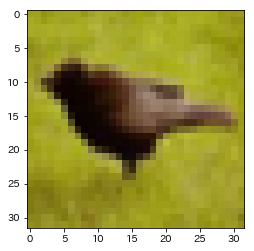

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

test_batch = train_iter.next()
x, t = test_batch[0]
chainer.config.train=False
prob = F.softmax(model.predictor(x[None]))
print('output probabilities : {}'.format(prob.data))  # [b'airplane', b'automobile', b'bird']
print('prediction : {}'.format(label_names[prob.data.argmax()]))
print('true          : {}'.format(label_names[t]))

img = x.reshape(3, 32, 32).transpose((1, 2, 0))
plt.figure()
plt.imshow(img)